# Assignment 4 CS 5316 Natural Language Processing

In [1]:
#Mount your google drive to this notebook

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/NLP/Assignment4

/content/gdrive/.shortcut-targets-by-id/1QU-Nm928liikIV4AYyrX-UOUxKStNUk_/NLP/Assignment4


In [3]:
import numpy as np
from IPython.display import Image
# Get the interactive Tools for Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from nltk import ngrams
import pandas as pd
import seaborn as sn
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, RepeatVector,Flatten, TimeDistributed, Input,Bidirectional,LocallyConnected1D,Conv1D,GlobalAveragePooling1D,GlobalMaxPooling1D,Concatenate,BatchNormalization
from tensorflow.keras.layers import Embedding, LSTM ,Dropout,GRU,SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
# import tensorflow.keras.utils.to_categorical as to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import math
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report
import pandas as pd
import csv

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Final Assingmnet
This is going to be the final assignment for deep learning. Here is a very good visual for what you will be doing with
<a href="https://ibb.co/mh9Ks0j">deep learning.</a> Lets get started.......

# TASK 1 Paraphrase Detection
For this task we will be using the [ Microsoft Research Paraphrase Corpus ](https://www.microsoft.com/en-us/download/details.aspx?id=52398). The corpus consist of sentence pairs with 1 or 0 labels which identify if the sentences are paraphrase or not respectively.
<br>
To perform this task we will be using recurrenct neural network for this task specifically the [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). RNN can be architected in multiple ways. Some of the possible ways are as follows:
<img src="archetecturernn.png">
The box in the bottom is the input, followed by the hidden layer (as the middle box), and the box on top is the output layer. The one-to-one architecture is the typical neural network (<i>vanila/Feed Forward</i>) with a hidden layer between the input and the output layer. Example uses of the above archetecture are as follows:
<ul>
    <li>One-to-many: input is an image and outputs are image captions</li>
    <li>Many-to-one: input is a movie's review <i>multiple words in input</i> and output is sentiment associated with the review <i>(we will be using a similar archetecture for our purpose)</i></li>
    <li>Many-to-many: machine translation of a sentence in one language to a sentence in another language, POS tagging etc</li>
</ul>
<br>
For this task we will also be using pre-trained word embeddings specificallly <a href="https://nlp.stanford.edu/projects/glove/">(GloVe Embeddings)</a>. Please download the paraphrase <a href="https://www.microsoft.com/en-us/download/details.aspx?id=52398">dataset</a> and glove.6B.zip from <a href="https://nlp.stanford.edu/projects/glove/">here</a>.

For this task you are required to implement the following archetecture, please use [keras functional API](https://www.tensorflow.org/guide/keras/functional) :
<img src="paraphrase.png">
If <a href="https://ibb.co/RSSjRM0">this</a> is you reaction after seeing the model archetecture dont worry we'll explain.
The model works as follows, there will be two inputs layers, one for each sentence followed by <b>shared</b> embedding layer which feed thier outputs to the shared LSTM, <b>take the final hidden state output</b> of both LSTM's and concatenate them. Finally feed the concatenated vector to a softmax output layer for classification.
<br>
<i>(The reason for using one shared embedding and LSTM layer so that the model learns sentence representation for all sentence pairs(x,x') in the dataset. If we were using two seperate LSTMS for x and x' we would need to double the dataset by having both (x,x') and (x',x) pairs so that both LSTM's see the entire train data distribution)</i>
The purpose for each layer in the model is as follows:
<ul>
    <li>Input takes the input sequences and feeds it to the next(you will need to specify the maximum size of a sentence as a parameter of this layer)</li>
    <li>Embedding layer, this layer takes the sequence input then for each word in the sequence generates a fixed size vector <i>(word embedding)</i>, this layer can be trained from scratch or can be configured to use pretrained embeddings with or without fine tuning. </li>
    <li>LSTM process the embedding vector sequences and at each step generates a hidden state vector(h)and cell memory vector(C)(<i>see diagram</i>), the keras LSTM layer returns three outputs (1) All the hidden states,(2) The final hidden state and (3) The final cell memory state<img src="lstm.png"></li>
    <li>The concatenation layer combines multple vectors into a single vector</li>
    <li>Finally the output layer predicts if sentence pairs were paraphrase or not</li>
</ul>
<b>Please refer to the TF-keras documentation for all the layers <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers">here</a></b>
<br><br><br>
Now that you understand the theoritical foundation for our approach lets move onto practical implementation.<br>
<h3>Data Preperation</h3>

<ul>
    <li> First we need to preprocess the data, convert the data to lower casing. Any other preprocessing procedures are optional but keep in mind that this will affect the performance of your model.</li>
    <li> To make training faster we will fix the maximum sequence length to 20 truncate the longer sequences.</li>
    <li> Split the data into test, train and validation in the ratio 20,70,10. Use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">scikit_test_train_split</a> <br><i><b>Hint:</b> use the splitter twice to get desired data splits.</i></li>
    <li> Next we need the vocabulary, vocabulary size and to convert sentences to numeric sequences by representing each word with a numeric value which will make our implementation easier later on, use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer">Tokenizer</a> from keras. <br><i>(Fit the tokenizer on train data and use the same tokenizer to convert train,test and validation data to numeric sequences)</i> </li>
    <li>  Use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences"> pad sequences</a> to add post padding to all sentences that are shorter than maximum sequence length
        <i>(<b>extra info</b>: fit_on_text reserves value/index 0 for padding and assigns numeric value to words starting from index 1)</i></li>
</ul>
<h3>Loading embeddings</h3>
<ul>
    <li> To use pretrained embeddings in tf keras embedding layer requires a dictionary, we need to create a dictionary whose keys will be numeric word representations and values will be the embedding vectors.</li>
    <li> First step is to load the word embedding pairs from the glove file into a dictionary.</li>
    <li> Next we will create a dictionary for our dataset's vocabulary. Copy all the word embeddings for words that are in our vocabulary and in the glove dictionary, if a word exists in our vocabulary but does not exist in glove dictionary create a zero vector of embedding dimension size and add it to the dictionary.</li>
</ul>
<h3>Create Model</h3>
<ul>
    <li> Create the model using <a href"https://www.tensorflow.org/guide/keras/functional">functional API</a></li>
    <li> Hints: The emebedding layer has a parameter that allows you to use pretrained embeddings, for shared layers read the section of shared layer weights in function API docs</li>

In [0]:
def loadData(filename):
    """
    Return preprocessed data
    
    Returns: X and Y where X is pair of sentence (x,x') and y is the label 0 or 1
    """
    df =  pd.read_csv(filename)
    df.columns = ['target','id1','id2','s1','s2']
    del df['id1']
    del df['id2']
    df.head()
    return df

In [0]:
def preprocessing(data):
    """
    Return preprocessed data

    Args:
        data : sentence pairs
    
    Returns: preprocessed_data
    preprocessed_data : preprocessed dataset 
    """
    #Doing the bare minimum pre-processing. Rest to be done in tokenizer/padding 
    data['s1'] = data['s1'].str.lower()
    data['s2'] = data['s2'].str.lower()
    return data

In [0]:
df_train = loadData("msr_paraphrase_train.csv")
df_train = preprocessing(df_train)
df_test = loadData("msr_paraphrase_test.csv")
df_test = preprocessing(df_test)

### Test train split
Use test train split from sklearn.


In [0]:
def testTrainSplit(data_X,data_Y):
    """
    Return test train data

    Args:
        data_X : sentence pairs
        data_Y: labels
        
    Returns: test train and validation split data 
    """
    #As asked in the email use only split the training into train and val. Use test as it is
    X_train, X_val, y_train, y_val = train_test_split(data_X, data_Y, test_size=0.1, random_state=1)
    return X_train,X_val,y_train,y_val

In [0]:
X_train,X_val,y_train,y_val = testTrainSplit(df_train[['s1','s2']],df_train[['target']])

In [0]:
X_test,y_test = df_test[['s1','s2']],df_test[['target']]

In [0]:
def combineList(X,first):
    #Joining the sentences into a list of list 
    slist = []
    if first:
        newSentences = X['s1']+' '+X['s2']
    else:
        newSentences = X['s2']+' '+X['s1']
    for val in newSentences:
        slist.append(str(val))
    return slist

In [0]:
listX_train1 = combineList(X_train,first=True)
listX_test1 = combineList(X_test,first=True)
listX_val1 = combineList(X_val,first=True)
listX_train2 = combineList(X_train,first=False)
listX_test2 = combineList(X_test,first=False)
listX_val2 = combineList(X_val,first=False)

In [0]:
y_trainhot = to_categorical(y_train)
y_testhot = to_categorical(y_test)
y_valhot = to_categorical(y_val)

Implement the step regarding keras Tokenizer in the cell below.<br>
<i> Keep in mind that each example is a pair/tupple of sentence(x,x'), combine them into a single sentence so that your data is a list of sentences before calling fit on text(Tokenizer). There is out of vocabulary option in tokenizer check that out aswell.</i>

In [0]:
# Get vocabular, vocabulary size and numeric word seqeunces for train,test and validation data
def doMagic(listX_train,listX_test,listX_val,maxlen=20):
    text_tokenizer = Tokenizer(lower=False,oov_token="<UNK>")
    text_tokenizer.fit_on_texts(listX_train)
    #Done creating sequences 
    sequence_X_train = text_tokenizer.texts_to_sequences(listX_train)
    sequence_X_test = text_tokenizer.texts_to_sequences(listX_test)
    sequence_X_val = text_tokenizer.texts_to_sequences(listX_val)
    #print(sequence_X_val)
    #Now need to create padded sequences
    padded_X_train = pad_sequences(sequence_X_train,maxlen=maxlen,padding="post")
    padded_X_test = pad_sequences(sequence_X_test,maxlen=maxlen,padding="post")
    padded_X_val = pad_sequences(sequence_X_val,maxlen=maxlen,padding="post")
    vocab = text_tokenizer.index_word
    vocab_size = len(vocab)+1
    #print(padded_X_train.shape)
    return padded_X_train,padded_X_test,padded_X_val,vocab,vocab_size
    

In [0]:
maxlen = 20

In [0]:
padded_X_train1,padded_X_test1,padded_X_val1,vocab,vocab_size = doMagic(listX_train1,listX_test1,listX_val1,maxlen)
padded_X_train2,padded_X_test2,padded_X_val2,_,_ = doMagic(listX_train2,listX_test2,listX_val2,maxlen)

Create the model in the cell below:
Try out different sizes for LSTM 50,100,300 and use relu activations. Also report results with Bi-LSTM as well.<br>
<i>To boost performance you can try adding a hidden layer between the lstm and output layer and also by adding a dropout layer in between different layers</i>

In [0]:
import os
EMBEDDING_DIM = 50
LSTM_SIZE = 50

In [0]:
def loadGlove(name,EMBEDDING_DIM,word_index):
    embeddings_index = {}
    f = open(name,encoding="utf-8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    print('Found %s word vectors.' % len(embeddings_index))
    return embedding_matrix

In [18]:
embedding_matrix = loadGlove("glove.6B.50d.txt",EMBEDDING_DIM=EMBEDDING_DIM,word_index=vocab)


Found 400000 word vectors.


In [19]:
type(embedding_matrix)

numpy.ndarray

In [20]:
# code model here
%cd /content/gdrive/My Drive/NLP/Assignment4
EMBEDDING_DIM = 50
LSTM_SIZE = 50
embedding_matrix = loadGlove("glove.6B.50d.txt",EMBEDDING_DIM=EMBEDDING_DIM,word_index=vocab)
inputA = Input(shape=(maxlen,))
inputB = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=vocab_size,output_dim=EMBEDDING_DIM,input_length=maxlen,weights=[embedding_matrix],
                           trainable=True)
shared_embedding_layer_1 = embedding_layer(inputA)
shared_embedding_layer_2 = embedding_layer(inputB)

shared_lstm = LSTM(LSTM_SIZE, return_sequences=True,return_state=True,recurrent_dropout=0.2)
_,last1,_ = shared_lstm(shared_embedding_layer_1)
_,last2,_ = shared_lstm(shared_embedding_layer_2)
concat = Concatenate()([last1,last2])
out = Dense(2,activation = "softmax",name="model1",)(concat)

model = Model(inputs=[inputA,inputB],outputs=out)
model.summary()


/content/gdrive/.shortcut-targets-by-id/1QU-Nm928liikIV4AYyrX-UOUxKStNUk_/NLP/Assignment4
Found 400000 word vectors.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 50)       651450      input_1[0][0]                    
                                                                 input_2[0][0]                    
____________________________________________________________________________

In [21]:
%cd /content/gdrive/My Drive/Results
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
filepath = "setting_" + "model1" + ".hdf5"
logfilepath = "setting_"+"model1" + ".csv"
reduce_lr_rate=0.2
logCallback = CSVLogger(logfilepath, separator=',', append=False)
earlyStopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_weights_only=True, verbose=1,
                             save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=reduce_lr_rate, patience=10,
                              cooldown=0, min_lr=0.0000000001, verbose=0)

callbacks_list = [logCallback, earlyStopping, reduce_lr, checkpoint]

/content/gdrive/My Drive/Results


In [22]:
model.fit([padded_X_train1,padded_X_train2],y_trainhot,epochs=100, batch_size=32,
                verbose=1,shuffle=True,callbacks=callbacks_list,
             validation_data=([padded_X_val1,padded_X_val2],y_valhot),use_multprocessing=True)

Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 0.6206 - accuracy: 0.6832
Epoch 00001: val_accuracy improved from -inf to 0.69853, saving model to setting_model1.hdf5
115/115 [==============================] - 17s 147ms/step - loss: 0.6206 - accuracy: 0.6832 - val_loss: 0.6032 - val_accuracy: 0.6985 - lr: 0.0010
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.4158 - accuracy: 0.8146
Epoch 00002: val_accuracy did not improve from 0.69853
115/115 [==============================] - 16s 138ms/step - loss: 0.4158 - accuracy: 0.8146 - val_loss: 0.7376 - val_accuracy: 0.6789 - lr: 0.0010
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.9299
Epoch 00003: val_accuracy did not improve from 0.69853
115/115 [==============================] - 16s 139ms/step - loss: 0.1806 - accuracy: 0.9299 - val_loss: 1.1005 - val_accuracy: 0.6201 - lr: 0.0010
Epoch 4/100
115/115 [==============================] - ETA: 0s - 

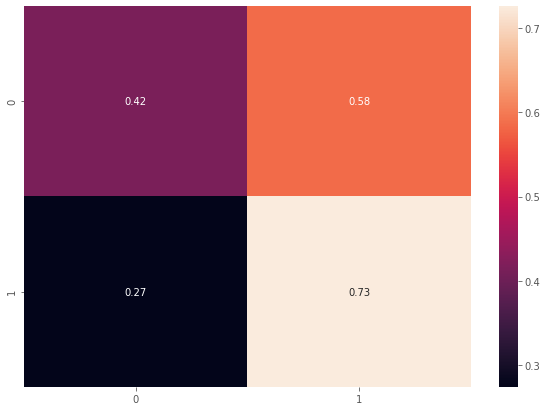

In [23]:
#predictions = code here
labelList=[0,1]
predictions = model.predict([padded_X_test1,padded_X_test2])
from sklearn.metrics import confusion_matrix
predictions = np.argmax(predictions,axis=-1)
test_Y_max=np.argmax(y_testhot, axis=-1)
cm=confusion_matrix(test_Y_max,predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, labelList,labelList )# matrix,names row,names col,
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)

In [24]:
print("Classification Report\n",classification_report(test_Y_max, predictions, labels=[0,1], target_names = ["Positive","Negative"]))

Classification Report
               precision    recall  f1-score   support

    Positive       0.43      0.42      0.42       578
    Negative       0.71      0.73      0.72      1147

    accuracy                           0.62      1725
   macro avg       0.57      0.57      0.57      1725
weighted avg       0.62      0.62      0.62      1725



In [25]:
# code model here
%cd /content/gdrive/My Drive/NLP/Assignment4
EMBEDDING_DIM = 200
LSTM_SIZE = 200
embedding_matrix = loadGlove("glove.6B.200d.txt",EMBEDDING_DIM=EMBEDDING_DIM,word_index=vocab)
inputA = Input(shape=(maxlen,))
inputB = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=vocab_size,output_dim=EMBEDDING_DIM,input_length=maxlen,weights=[embedding_matrix],
                           trainable=True)
shared_embedding_layer_1 = embedding_layer(inputA)
shared_embedding_layer_2 = embedding_layer(inputB)

shared_lstm = LSTM(LSTM_SIZE, return_sequences=True,return_state=True,recurrent_dropout=0.2)
_,last1,_= shared_lstm(shared_embedding_layer_1)
_,last2,_ = shared_lstm(shared_embedding_layer_2)
concat = Concatenate()([last1,last2])
out = Dense(2,activation = "softmax",name="model1",)(concat)

model = Model(inputs=[inputA,inputB],outputs=out)
model.summary()


/content/gdrive/.shortcut-targets-by-id/1QU-Nm928liikIV4AYyrX-UOUxKStNUk_/NLP/Assignment4
Found 400000 word vectors.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 200)      2605800     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________

In [26]:
%cd /content/gdrive/My Drive/Results
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
filepath = "setting_" + "model2" + ".hdf5"
logfilepath = "setting_"+"model2" + ".csv"
reduce_lr_rate=0.2
logCallback = CSVLogger(logfilepath, separator=',', append=False)
earlyStopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_weights_only=True, verbose=1,
                             save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=reduce_lr_rate, patience=10,
                              cooldown=0, min_lr=0.0000000001, verbose=0)

callbacks_list = [logCallback, earlyStopping, reduce_lr, checkpoint]
model.fit([padded_X_train1,padded_X_train2],y_trainhot,epochs=100, batch_size=32,
                verbose=1,shuffle=True,callbacks=callbacks_list,
             validation_data=([padded_X_val1,padded_X_val2],y_valhot),use_multprocessing=True)

/content/gdrive/My Drive/Results
Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 0.6133 - accuracy: 0.6878
Epoch 00001: val_accuracy improved from -inf to 0.69608, saving model to setting_model2.hdf5
115/115 [==============================] - 19s 169ms/step - loss: 0.6133 - accuracy: 0.6878 - val_loss: 0.6018 - val_accuracy: 0.6961 - lr: 0.0010
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.3756 - accuracy: 0.8405
Epoch 00002: val_accuracy did not improve from 0.69608
115/115 [==============================] - 18s 157ms/step - loss: 0.3756 - accuracy: 0.8405 - val_loss: 0.8637 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.9422
Epoch 00003: val_accuracy did not improve from 0.69608
115/115 [==============================] - 18s 155ms/step - loss: 0.1569 - accuracy: 0.9422 - val_loss: 0.8483 - val_accuracy: 0.5907 - lr: 0.0010
Epoch 4/100
115/115 [===========

Use the <b>model.predict</b> method to get predictions. There predictions will be a probability distribution over the lables, to get the desired class take the max value in a prediction vector as the predicted class.<br>

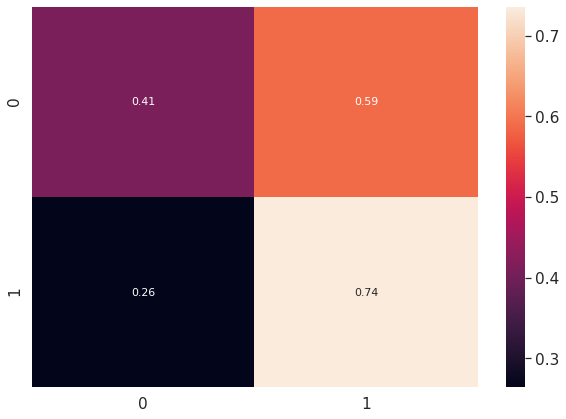

          0         1
0  0.410035  0.589965
1  0.264167  0.735833


In [27]:
#predictions = code here
labelList=[0,1]
predictions = model.predict([padded_X_test1,padded_X_test2])
from sklearn.metrics import confusion_matrix
predictions = np.argmax(predictions,axis=-1)
test_Y_max=np.argmax(y_testhot, axis=-1)
cm=confusion_matrix(test_Y_max,predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, labelList,labelList )# matrix,names row,names col,
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()
print(cm)

In [28]:
print("Classification Report\n",classification_report(test_Y_max, predictions, labels=[0,1], target_names = ["Positive","Negative"]))

Classification Report
               precision    recall  f1-score   support

    Positive       0.44      0.41      0.42       578
    Negative       0.71      0.74      0.72      1147

    accuracy                           0.63      1725
   macro avg       0.58      0.57      0.57      1725
weighted avg       0.62      0.63      0.62      1725



In [29]:
# code model here
%cd /content/gdrive/My Drive/NLP/Assignment4
EMBEDDING_DIM = 300
LSTM_SIZE = 300
embedding_matrix = loadGlove("glove.6B.300d.txt",EMBEDDING_DIM=EMBEDDING_DIM,word_index=vocab)
inputA = Input(shape=(maxlen,))
inputB = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=vocab_size,output_dim=EMBEDDING_DIM,input_length=maxlen,weights=[embedding_matrix],
                           trainable=True)
shared_embedding_layer_1 = embedding_layer(inputA)
shared_embedding_layer_2 = embedding_layer(inputB)

shared_lstm = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True,return_state=True,recurrent_dropout=0.2))
_,last11,_,last12,_ = shared_lstm(shared_embedding_layer_1)
_,last21,_,last22,_ = shared_lstm(shared_embedding_layer_2)
concat = Concatenate()([last11,last12,last21,last22])
out = Dense(2,activation = "softmax",name="model1",)(concat)

model = Model(inputs=[inputA,inputB],outputs=out)
model.summary()


/content/gdrive/.shortcut-targets-by-id/1QU-Nm928liikIV4AYyrX-UOUxKStNUk_/NLP/Assignment4
Found 400000 word vectors.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 300)      3908700     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________

In [30]:
%cd /content/gdrive/My Drive/Results
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
filepath = "setting_" + "model3" + ".hdf5"
logfilepath = "setting_"+"model3" + ".csv"
reduce_lr_rate=0.2
logCallback = CSVLogger(logfilepath, separator=',', append=False)
earlyStopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_weights_only=True, verbose=1,
                             save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=reduce_lr_rate, patience=10,
                              cooldown=0, min_lr=0.0000000001, verbose=0)

callbacks_list = [logCallback, earlyStopping, reduce_lr, checkpoint]
model.fit([padded_X_train1,padded_X_train2],y_trainhot,epochs=100, batch_size=32,
                verbose=1,shuffle=True,callbacks=callbacks_list,
             validation_data=([padded_X_val1,padded_X_val2],y_valhot),use_multprocessing=True)

/content/gdrive/My Drive/Results
Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 0.6140 - accuracy: 0.6881
Epoch 00001: val_accuracy improved from -inf to 0.69363, saving model to setting_model3.hdf5
115/115 [==============================] - 36s 312ms/step - loss: 0.6140 - accuracy: 0.6881 - val_loss: 0.6057 - val_accuracy: 0.6936 - lr: 0.0010
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.3568 - accuracy: 0.8525
Epoch 00002: val_accuracy did not improve from 0.69363
115/115 [==============================] - 34s 296ms/step - loss: 0.3568 - accuracy: 0.8525 - val_loss: 0.8058 - val_accuracy: 0.6814 - lr: 0.0010
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.9656
Epoch 00003: val_accuracy did not improve from 0.69363
115/115 [==============================] - 34s 296ms/step - loss: 0.1081 - accuracy: 0.9656 - val_loss: 0.9525 - val_accuracy: 0.6225 - lr: 0.0010
Epoch 4/100
115/115 [===========

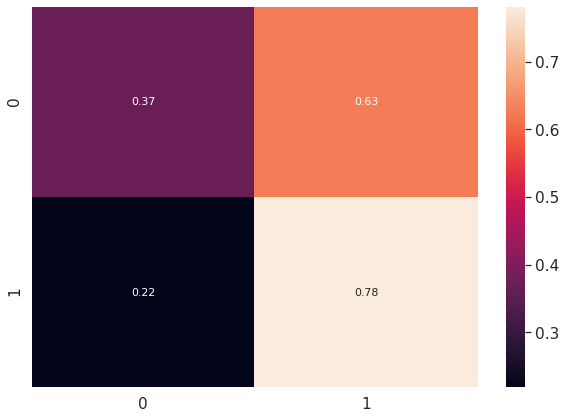

          0         1
0  0.371972  0.628028
1  0.218832  0.781168


In [31]:
#predictions = code here
labelList=[0,1]
predictions = model.predict([padded_X_test1,padded_X_test2])
from sklearn.metrics import confusion_matrix
predictions = np.argmax(predictions,axis=-1)
test_Y_max=np.argmax(y_testhot, axis=-1)
cm=confusion_matrix(test_Y_max,predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, labelList,labelList )# matrix,names row,names col,
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()
print(cm)

In [32]:
print("Classification Report\n",classification_report(test_Y_max, predictions, labels=[0,1], target_names = ["Positive","Negative"]))

Classification Report
               precision    recall  f1-score   support

    Positive       0.46      0.37      0.41       578
    Negative       0.71      0.78      0.74      1147

    accuracy                           0.64      1725
   macro avg       0.59      0.58      0.58      1725
weighted avg       0.63      0.64      0.63      1725



# Task 2 Sentiment Classification
For this task we will be reusing the movie reviews dataset available on <a href="https://www.kaggle.com/c/word2vec-nlp-tutorial/data">kaggle</a> and download the dataset from there. 
We will be using the unlabeledTrainData file and labeledTrainData file. We will use the gensim package to train word2vec embeddings using [gensim](https://radimrehurek.com/gensim/) package and unlabelled train data as in the previous assignmnet. Now instead for creating a single representation for each review we will be using deep learning models for this task. We will use the same archetecture as before but will experiment with different reccurant networks namely RNN, GRU and LSTM.<br> This task might feel like <a href="https://ibb.co/Tgh2XyH">this</a> but since this is a deep learning assignment thus we must use it.
<h3>Data Preperation</h3>
<ul>
    <li> First we need to preprocess the data, convert the data to lower casing(both files). Any other preprocessing procedures are optional but keep in mind that this will affect the performance of your model.</li>
    <li> Split the labeledTrainData data file into test, train and validation in the ratio 20,70,10. Use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">scikit_test_train_split</a> <br><i><b>Hint:</b> use the splitter twice to get desired data splits.</i></li>
    <li> Next we need the vocabulary, vocabulary size and to convert sentences to numeric sequences by representing each word with a numeric value which will make our implementation easier later on, use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer">Tokenizer</a> from keras. <br><i>(Fit the tokenizer on train data and use the same tokenizer to convert train,test and validation data to numeric sequences)</i> </li>
    <li>  Use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences"> pad sequences</a> to add post padding to all sentences that are shorter than maximum sequence length</li>
    <li> Use one hot representation for targets/labels, you can use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">scikit learn</a> or <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing">keras preprocessing</a>.</li>
</ul>
<h3>Loading embeddings</h3>
<ul>
    <li> As state before use the gensim package to train the word2vec model on unlabelledTrainData file</li>
    <li> Next we will create a dictionary for our dataset's vocabulary. Copy all the word embeddings for words that are in our vocabulary and in the word2vec model, if a word exists in our vocabulary but does not exist in word2vec model create a zero vector of embedding dimension size and add it to the dictionary.</li>
</ul>
<h3>Create Model</h3>
<ul>
    <li> Here is a visual for the model <img src="sentimentdeep.png">
    <li> Create the model using <a href"https://www.tensorflow.org/guide/keras/functional">functional API</a> or the <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Sequential">Sequential API</a></li>
    <li> Hints: The emebedding layer has a parameter that allows you to use pretrained embeddings</li>



Use can reuse the code snippets from above for call backs, prediction heat map and classification report
<i>You will have provide a label list for this specific dataset inorder for them to run, you are to make the required changes yourself</i>

In [33]:
%cd /content/gdrive/My Drive/NLP/Assignment4

/content/gdrive/.shortcut-targets-by-id/1QU-Nm928liikIV4AYyrX-UOUxKStNUk_/NLP/Assignment4


In [0]:
dft2 = pd.read_csv("labeledTrainData.tsv",sep="\t")


In [0]:
del(dft2['id'])

In [0]:
def preprocessing(data):
    """
    Return preprocessed data

    Args:
        data : sentence pairs
    
    Returns: preprocessed_data
    preprocessed_data : preprocessed dataset 
    """
    #Doing the bare minimum pre-processing. Rest to be done in tokenizer/padding 
    data['review'] = data['review'].str.lower()
    return data

In [37]:
dft2.head()
x = dft2[['review']]
y = dft2[['sentiment']]
x = preprocessing(x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [38]:
x.head()

,review
0,with all this stuff going down at the moment w...
1,"\the classic war of the worlds\"" by timothy hi..."
2,the film starts with a manager (nicholas bell)...
3,it must be assumed that those who praised this...
4,superbly trashy and wondrously unpretentious 8...


In [0]:
def testTrainSplit1(data_X,data_Y):
    """
    Return test train data

    Args:
        data_X : sentence pairs
        data_Y: labels
        
    Returns: test train and validation split data 
    """
    #Training this bish function to do 70,20,10 split
    X_train, X_val, y_train, y_val = train_test_split(data_X, data_Y, test_size=0.1, random_state=1)
    X_train,X_test,y_train,y_test = train_test_split(data_X,data_Y,test_size=0.22,random_state=1) #0.22*0.9 ~= 20 percent of original data. Consecutive discount  
    return X_train,X_test,X_val,y_train,y_test,y_val

In [0]:
X_train,X_test,X_val,y_train,y_test,y_val = testTrainSplit1(x,y)

In [0]:
def combineList(X):
    #Joining the sentences into a list of list 
    slist = []
    for val in X['review']:
        slist.append(str(val))
    return slist


In [0]:
X_train_list = combineList(X_train)
X_test_list = combineList(X_test)
X_val_list = combineList(X_val)
y_trainhot = to_categorical(y_train)
y_testhot = to_categorical(y_test)
y_valhot = to_categorical(y_val)

In [0]:
padded_X_train,padded_X_test,padded_X_val,vocab,vocab_size = doMagic(X_train_list,X_test_list,X_val_list)

In [44]:
unlabeledTrain = pd.read_csv("unlabeledTrainData.tsv",sep="\t",error_bad_lines=False)
unlabeledTrain.head()
del unlabeledTrain['id']
unlabeledTrain = preprocessing(unlabeledTrain)

b'Skipping line 43043: expected 2 fields, saw 3\n'


In [45]:
len(unlabeledTrain)
unlabeledTrain.head()

,review
0,"watching time chasers, it obvious that it was ..."
1,i saw this film about 20 years ago and remembe...
2,"minor spoilers<br /><br />in new york, joan ba..."
3,i went to see this film with a great deal of e...
4,"yes, i agree with everyone on this site this m..."


In [0]:
listdata = unlabeledTrain['review'].str.split()

In [0]:
combineList = []
for review in listdata:
  combineList.append(review)

In [0]:
from gensim.models import Word2Vec
EMBEDING_DIM = 50

In [49]:
wordVecModel = Word2Vec(combineList,size=EMBEDING_DIM)
words = list(wordVecModel.wv.vocab) #dictionary of wordvec model is words 
%cd /content/gdrive/My Drive/Results

/content/gdrive/My Drive/Results


In [0]:
embeedingDict = {}
for word in words:
  embeedingDict[word] = wordVecModel.wv.get_vector(word)

In [0]:
def loadEmbeedings(word_index,embeddings_index):
  embedding_matrix = np.zeros((len(word_index) + 1, EMBEDING_DIM))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector

  print('Found %s word vectors.' % len(embeddings_index))
  return embedding_matrix

In [56]:
embeeding_matrix = loadEmbeedings(vocab,embeedingDict)

Found 72507 word vectors.


In [57]:
y_trainhot.shape

(19500, 2)

In [58]:
# code model here
%cd /content/gdrive/My Drive/NLP/Assignment4
LSTM_SIZE = 50
maxlen = 20
inputA = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=vocab_size,output_dim=EMBEDING_DIM,input_length=maxlen,weights=[embeeding_matrix],
                           trainable=True)(inputA)

_,last1,_ = LSTM(LSTM_SIZE, return_sequences=True,return_state=True,recurrent_dropout=0.2)(embedding_layer)
out = Dense(2,activation = "softmax",name="model4",)(last1)

model = Model(inputs=inputA,outputs=out)
model.summary()


/content/gdrive/.shortcut-targets-by-id/1QU-Nm928liikIV4AYyrX-UOUxKStNUk_/NLP/Assignment4
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 20, 50)            3970050   
_________________________________________________________________
lstm_3 (LSTM)                [(None, 20, 50), (None, 5 20200     
_________________________________________________________________
model4 (Dense)               (None, 2)                 102       
Total params: 3,990,352
Trainable params: 3,990,352
Non-trainable params: 0
_________________________________________________________________


In [59]:
%cd /content/gdrive/My Drive/Results
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
filepath = "setting_" + "model4" + ".hdf5"
logfilepath = "setting_"+"model4" + ".csv"
reduce_lr_rate=0.2
logCallback = CSVLogger(logfilepath, separator=',', append=False)
earlyStopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_weights_only=True, verbose=1,
                             save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=reduce_lr_rate, patience=10,
                              cooldown=0, min_lr=0.0000000001, verbose=0)

callbacks_list = [logCallback, earlyStopping, reduce_lr, checkpoint]
model.fit(padded_X_train,y_trainhot,epochs=100, batch_size=32,
                verbose=1,shuffle=True,callbacks=callbacks_list,
             validation_data=(padded_X_val,y_valhot),use_multprocessing=True)

/content/gdrive/My Drive/Results
Epoch 1/100
610/610 [==============================] - ETA: 0s - loss: 0.5284 - accuracy: 0.7256
Epoch 00001: val_accuracy improved from -inf to 0.76640, saving model to setting_model4.hdf5
610/610 [==============================] - 66s 108ms/step - loss: 0.5284 - accuracy: 0.7256 - val_loss: 0.4839 - val_accuracy: 0.7664 - lr: 0.0010
Epoch 2/100
610/610 [==============================] - ETA: 0s - loss: 0.3414 - accuracy: 0.8503
Epoch 00002: val_accuracy did not improve from 0.76640
610/610 [==============================] - 63s 103ms/step - loss: 0.3414 - accuracy: 0.8503 - val_loss: 0.5250 - val_accuracy: 0.7612 - lr: 0.0010
Epoch 3/100
610/610 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9150
Epoch 00003: val_accuracy did not improve from 0.76640
610/610 [==============================] - 62s 102ms/step - loss: 0.2151 - accuracy: 0.9150 - val_loss: 0.6520 - val_accuracy: 0.7392 - lr: 0.0010
Epoch 4/100
610/610 [===========

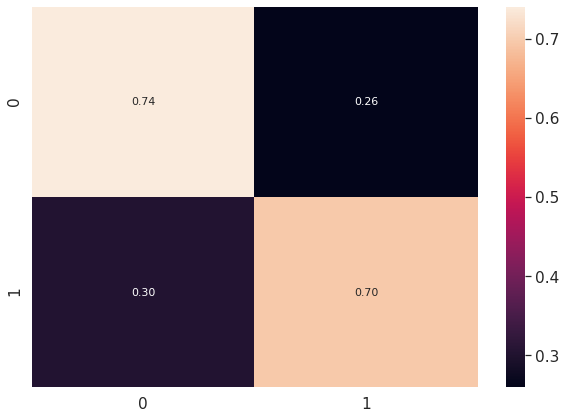

          0         1
0  0.740527  0.259473
1  0.303774  0.696226


In [60]:
#predictions = code here
labelList=[0,1]
predictions = model.predict(padded_X_test)
from sklearn.metrics import confusion_matrix
predictions = np.argmax(predictions,axis=-1)
test_Y_max=np.argmax(y_testhot, axis=-1)
cm=confusion_matrix(test_Y_max,predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, labelList,labelList )# matrix,names row,names col,
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()
print(cm)

In [61]:
print("Classification Report\n",classification_report(test_Y_max, predictions, labels=[0,1], target_names = ["Positive","Negative"]))

Classification Report
               precision    recall  f1-score   support

    Positive       0.71      0.74      0.73      2771
    Negative       0.73      0.70      0.71      2729

    accuracy                           0.72      5500
   macro avg       0.72      0.72      0.72      5500
weighted avg       0.72      0.72      0.72      5500



In [62]:
# code model here
%cd /content/gdrive/My Drive/NLP/Assignment4
LSTM_SIZE = 50
maxlen = 20
inputA = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=vocab_size,output_dim=EMBEDING_DIM,input_length=maxlen,weights=[embeeding_matrix],
                           trainable=True)
shared_embedding_layer_1 = embedding_layer(inputA)

shared_lstm = GRU(LSTM_SIZE, return_sequences=True,return_state=True,recurrent_dropout=0.2)
_,last1 = shared_lstm(shared_embedding_layer_1)
out = Dense(2,activation = "softmax",name="model5",)(last1)

model = Model(inputs=inputA,outputs=out)
model.summary()


/content/gdrive/.shortcut-targets-by-id/1QU-Nm928liikIV4AYyrX-UOUxKStNUk_/NLP/Assignment4
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 20, 50)            3970050   
_________________________________________________________________
gru (GRU)                    [(None, 20, 50), (None, 5 15300     
_________________________________________________________________
model5 (Dense)               (None, 2)                 102       
Total params: 3,985,452
Trainable params: 3,985,452
Non-trainable params: 0
_________________________________________________________________


In [63]:
%cd /content/gdrive/My Drive/Results
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
filepath = "setting_" + "model5" + ".hdf5"
logfilepath = "setting_"+"model5" + ".csv"
reduce_lr_rate=0.2
logCallback = CSVLogger(logfilepath, separator=',', append=False)
earlyStopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_weights_only=True, verbose=1,
                             save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=reduce_lr_rate, patience=10,
                              cooldown=0, min_lr=0.0000000001, verbose=0)

callbacks_list = [logCallback, earlyStopping, reduce_lr, checkpoint]
model.fit(padded_X_train,y_trainhot,epochs=100, batch_size=32,
                verbose=1,shuffle=True,callbacks=callbacks_list,
             validation_data=(padded_X_val,y_valhot),use_multprocessing=True)

/content/gdrive/My Drive/Results
Epoch 1/100
610/610 [==============================] - ETA: 0s - loss: 0.5328 - accuracy: 0.7230
Epoch 00001: val_accuracy improved from -inf to 0.77800, saving model to setting_model5.hdf5
610/610 [==============================] - 60s 98ms/step - loss: 0.5328 - accuracy: 0.7230 - val_loss: 0.4706 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 2/100
610/610 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8493
Epoch 00002: val_accuracy did not improve from 0.77800
610/610 [==============================] - 59s 96ms/step - loss: 0.3408 - accuracy: 0.8493 - val_loss: 0.5115 - val_accuracy: 0.7616 - lr: 0.0010
Epoch 3/100
610/610 [==============================] - ETA: 0s - loss: 0.2236 - accuracy: 0.9114
Epoch 00003: val_accuracy did not improve from 0.77800
610/610 [==============================] - 58s 96ms/step - loss: 0.2236 - accuracy: 0.9114 - val_loss: 0.6103 - val_accuracy: 0.7520 - lr: 0.0010
Epoch 4/100
610/610 [==============

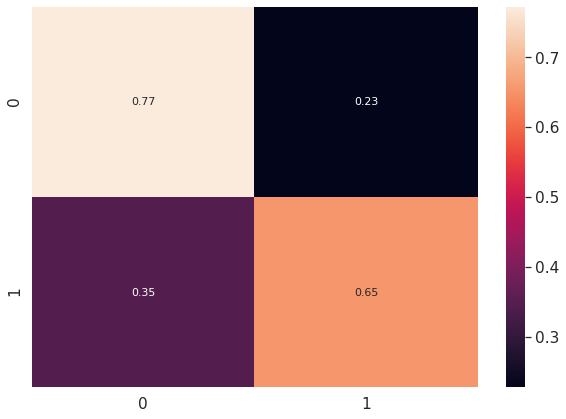

          0         1
0  0.771923  0.228077
1  0.347014  0.652986


In [64]:
#predictions = code here
labelList=[0,1]
predictions = model.predict(padded_X_test)
from sklearn.metrics import confusion_matrix
predictions = np.argmax(predictions,axis=-1)
test_Y_max=np.argmax(y_testhot, axis=-1)
cm=confusion_matrix(test_Y_max,predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, labelList,labelList )# matrix,names row,names col,
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()
print(cm)

In [65]:
print("Classification Report\n",classification_report(test_Y_max, predictions, labels=[0,1], target_names = ["Positive","Negative"]))

Classification Report
               precision    recall  f1-score   support

    Positive       0.69      0.77      0.73      2771
    Negative       0.74      0.65      0.69      2729

    accuracy                           0.71      5500
   macro avg       0.72      0.71      0.71      5500
weighted avg       0.72      0.71      0.71      5500



In [66]:
# code model here
%cd /content/gdrive/My Drive/NLP/Assignment4
LSTM_SIZE = 50
maxlen = 20
inputA = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=vocab_size,output_dim=EMBEDING_DIM,input_length=maxlen,weights=[embeeding_matrix],
                           trainable=True)
shared_embedding_layer_1 = embedding_layer(inputA)

shared_lstm = SimpleRNN(LSTM_SIZE, return_sequences=True,return_state=True,recurrent_dropout=0.2)
_,last1 = shared_lstm(shared_embedding_layer_1)
out = Dense(2,activation = "softmax",name="model6",)(last1)

model = Model(inputs=inputA,outputs=out)
model.summary()


/content/gdrive/.shortcut-targets-by-id/1QU-Nm928liikIV4AYyrX-UOUxKStNUk_/NLP/Assignment4
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 20, 50)            3970050   
_________________________________________________________________
simple_rnn (SimpleRNN)       [(None, 20, 50), (None, 5 5050      
_________________________________________________________________
model6 (Dense)               (None, 2)                 102       
Total params: 3,975,202
Trainable params: 3,975,202
Non-trainable params: 0
_________________________________________________________________


In [67]:
%cd /content/gdrive/My Drive/Results
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
filepath = "setting_" + "model6" + ".hdf5"
logfilepath = "setting_"+"model6" + ".csv"
reduce_lr_rate=0.2
logCallback = CSVLogger(logfilepath, separator=',', append=False)
earlyStopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_weights_only=True, verbose=1,
                             save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=reduce_lr_rate, patience=10,
                              cooldown=0, min_lr=0.0000000001, verbose=0)

callbacks_list = [logCallback, earlyStopping, reduce_lr, checkpoint]
model.fit(padded_X_train,y_trainhot,epochs=100, batch_size=32,
                verbose=1,shuffle=True,callbacks=callbacks_list,
             validation_data=(padded_X_val,y_valhot),use_multprocessing=True)

/content/gdrive/My Drive/Results
Epoch 1/100
609/610 [============================>.] - ETA: 0s - loss: 0.5884 - accuracy: 0.6691
Epoch 00001: val_accuracy improved from -inf to 0.76160, saving model to setting_model6.hdf5
610/610 [==============================] - 34s 57ms/step - loss: 0.5882 - accuracy: 0.6691 - val_loss: 0.4950 - val_accuracy: 0.7616 - lr: 0.0010
Epoch 2/100
610/610 [==============================] - ETA: 0s - loss: 0.3956 - accuracy: 0.8243
Epoch 00002: val_accuracy improved from 0.76160 to 0.77280, saving model to setting_model6.hdf5
610/610 [==============================] - 34s 55ms/step - loss: 0.3956 - accuracy: 0.8243 - val_loss: 0.5153 - val_accuracy: 0.7728 - lr: 0.0010
Epoch 3/100
610/610 [==============================] - ETA: 0s - loss: 0.2764 - accuracy: 0.8886
Epoch 00003: val_accuracy did not improve from 0.77280
610/610 [==============================] - 33s 54ms/step - loss: 0.2764 - accuracy: 0.8886 - val_loss: 0.6060 - val_accuracy: 0.7420 - lr: 0

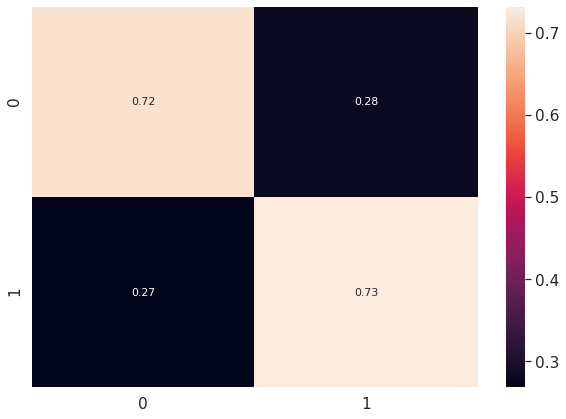

          0         1
0  0.720318  0.279682
1  0.268230  0.731770


In [68]:
#predictions = code here
labelList=[0,1]
predictions = model.predict(padded_X_test)
from sklearn.metrics import confusion_matrix
predictions = np.argmax(predictions,axis=-1)
test_Y_max=np.argmax(y_testhot, axis=-1)
cm=confusion_matrix(test_Y_max,predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, labelList,labelList )# matrix,names row,names col,
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()
print(cm)

In [69]:
print("Classification Report\n",classification_report(test_Y_max, predictions, labels=[0,1], target_names = ["Positive","Negative"]))

Classification Report
               precision    recall  f1-score   support

    Positive       0.73      0.72      0.73      2771
    Negative       0.72      0.73      0.73      2729

    accuracy                           0.73      5500
   macro avg       0.73      0.73      0.73      5500
weighted avg       0.73      0.73      0.73      5500



`Ckearly Simple RNN has slightly more accuracy than LSTM and GRU`

# We hope all of you are working on your projects and <a href="https://ibb.co/dcpf4vS"> Kudos for completing the assingnment</a>